GitHub: https://github.com/elsanns/xai-explain-notebooks/

# Content
---
This notebook contains an example of two feature attribution methods applied to a PyTorch model predicting fuel efficiency for the [Auto MPG Data Set](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data). 

We will use the following methods:
- [Integrated Gradients from the Captum package](https://captum.ai/api/integrated_gradients.html)
- custom toy implementation of the [SHAP algorithm (Shapley values)](https://en.wikipedia.org/wiki/Shapley_value)

Attribution methods are applied per sample. As a result, each  feature is assigned a value reflecting its contribution to the model's output or, more precisely, to the difference between model's output for the sample and the *expected value*. 

Both methods used in this notebook require setting a baseline, i.e.: a vector of values that will be used, for each feature, in place of a missing value. The baseline vector serves as a set of reference values that can be thought of as *neutral* and that are used to represent a missing value whenever a method requires it. We will calculate the *expected value* as model's output for a selected baseline. 

All attributions together account for the difference between the model's prediction for a sample and the expected value of the model's output for a selected baseline. 


In the examples below we will consider various baselines and see how they influence assigning importance to features.
We will see that, for each sample, attributions sum up to the difference between model's output for the sample and the *expected value* (model's output for the baseline used to compute attributions).

# Install and import packages

---

In [0]:
! pip install captum

In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from tensorflow import keras

from captum.attr import IntegratedGradients

from itertools import chain, combinations
import scipy.special

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

# Load, clean and pre-process data

---

In [0]:
# Some code for data pre-processing and cleaning and the model structure 
# (originally in TF/Keras) borrowed from:
# https://www.tensorflow.org/tutorials/keras/regression 

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset_raw = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset_raw = dataset_raw.dropna()
dataset_raw['Origin'] = dataset_raw['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = dataset_raw.copy()

dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
column_names = column_names[:-1] + ['Europe', 'Japan', 'USA']
print(column_names)

dataset.head()

['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Europe', 'Japan', 'USA']


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


Prepare train and test set

In [0]:
# Split into train and test set
X_train = dataset.sample(frac=0.8,random_state=0)
X_test = dataset.drop(X_train.index)
y_train = np.array(X_train.pop('MPG'))
y_test = np.array(X_test.pop('MPG'))

# Rescale data to [0, 1]
X_train = np.array((X_train - X_train.min())/(X_train.max() - X_train.min()))
X_test = np.array((X_test - X_test.min())/(X_test.max() - X_test.min()))

# Convert to tensors
X_train_pt = torch.tensor(X_train).float()
X_test_pt = torch.tensor(X_test).float()
y_train_pt = torch.tensor(y_train).view(-1, 1).float()
y_test_pt = torch.tensor(y_test).view(-1, 1).float()

Visualize

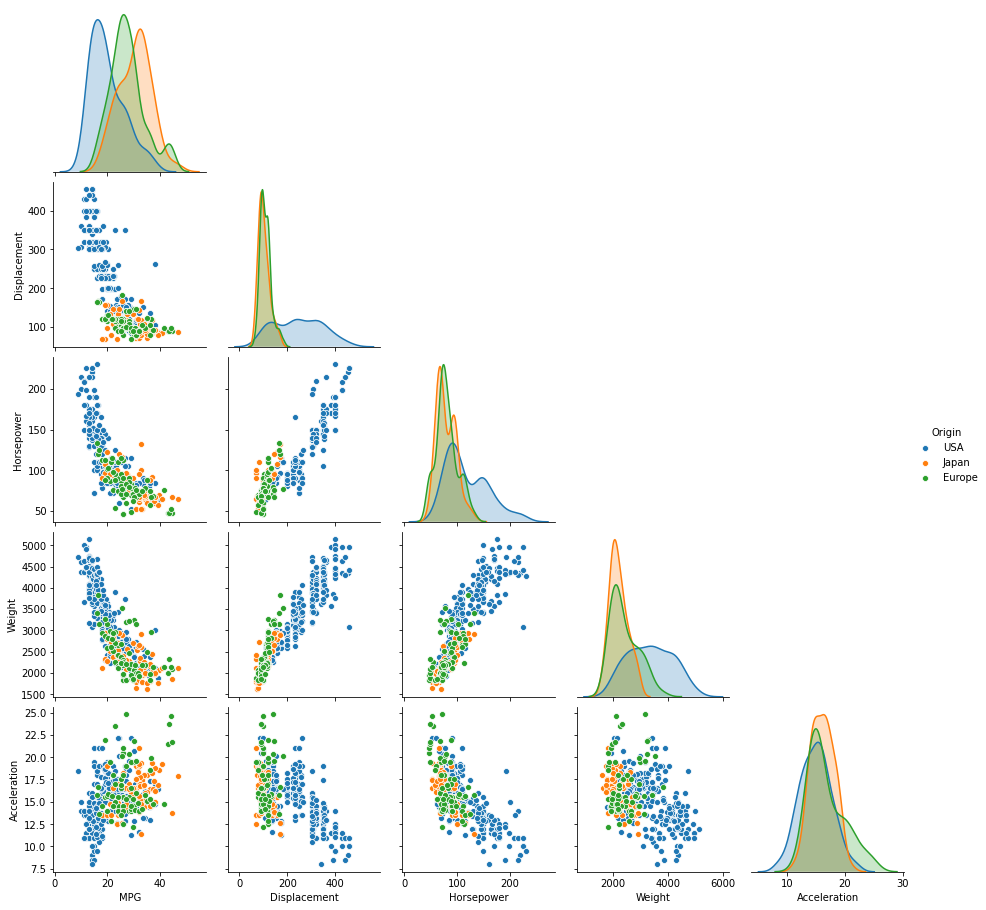

In [0]:
# Plot correlations between features (and target) to gain insight into the data 

dataset_plot = dataset_raw.copy()
dataset_plot = dataset_plot[["MPG", "Origin"]+column_names[2:6]]
sns.pairplot(dataset_plot, hue="Origin", corner=True)

del dataset_plot

# Create a PyTorch model

---

Build and train a simple PyTorch model

In [0]:
class CarFuelEfficiency(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(X_train.shape[-1], 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()         
        self.out = nn.Linear(64, 1)
        
    def forward(self, input):
        x = self.relu1(self.dense1(input))
        x = self.relu2(self.dense2(x))
        return self.out(x)

Instantiate the model

In [0]:
# Set seeds for reproducibility, before instantiating, for the settings to affect
# weight initialization
np.random.seed(1234) # 123
torch.manual_seed(1234)

# Instantiate
model = CarFuelEfficiency()
model.training

True

Set parameters

In [0]:
# Parameters
learning_rate = 0.001
batch_size = 10
num_epochs = 1000 

# Plot
COLOR_BLUE = '#1f77b4'

Data serving

In [0]:
datasets = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

Set device

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(next(model.parameters()).is_cuda)

# Put test data on the selected device
X_test_pt = X_test_pt.to(device)

True


# Train

---

Training function

In [0]:
# Train function
criterion = nn.MSELoss(reduction='sum')
def train_model(model, num_epochs=num_epochs):
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            # Compute gradients
            loss.backward()
            running_loss += loss.item()
            # Update weights
            optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:    
            print("Epoch {}/{} running accumulative loss across all batches: {}"\
                  .format(epoch + 1, num_epochs, round(running_loss,4)))
        running_loss = 0.0  

Run training

In [0]:
train_model(model, num_epochs=num_epochs)

Epoch 1/1000 running accumulative loss across all batches: 107031.1505
Epoch 101/1000 running accumulative loss across all batches: 2362.4077
Epoch 201/1000 running accumulative loss across all batches: 2101.907
Epoch 301/1000 running accumulative loss across all batches: 1869.3306
Epoch 401/1000 running accumulative loss across all batches: 1785.5416
Epoch 501/1000 running accumulative loss across all batches: 1726.0519
Epoch 601/1000 running accumulative loss across all batches: 1594.8865
Epoch 701/1000 running accumulative loss across all batches: 1588.6552
Epoch 801/1000 running accumulative loss across all batches: 1567.7207
Epoch 901/1000 running accumulative loss across all batches: 1486.6474
Epoch 1000/1000 running accumulative loss across all batches: 1426.307


# Predict 

---

In [0]:
test_predictions_pt = model(X_test_pt)
test_predictions = test_predictions_pt.clone().to('cpu').detach().numpy().flatten()

Plot results and calculate prediction error

Mean err %: -0.013988957822294243


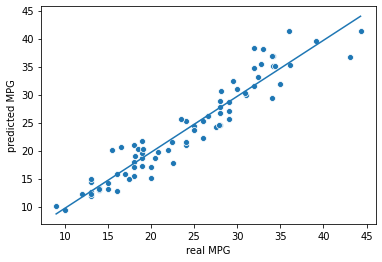

In [0]:
# Mean difference from the ground truth, relative to the ground truth value
print("Mean err %:", np.mean((test_predictions - y_test) / y_test).flatten()[0])

# Plot
sns.scatterplot(x=y_test, y=test_predictions)
# fit a line (ax+b)
line_coefs = np.polyfit(y_test, test_predictions, 1)
y_line = list(map(lambda x: line_coefs[0]*x+line_coefs[1], y_test))
sns.lineplot(y_test, y_line)
plt.xlabel('real MPG')
plt.ylabel('predicted MPG')
plt.ioff()

# Try various baselines

---

Both methods: Integrated Gradients and SHAP need to be provided a vector of baseline values for each feature. The values represent missing features and are use to calculate the impact of their *absence*.
All attributions together account for the difference between the model's output for a sample and the expected value for the baseline selected.
If the approximation of attributions is precise enough, the sum of attributions per row should equal to the difference between the expected value and the model's output for that row.
To calculate the *expected value* we run the model to obtain its prediction for an artificial sample of baseline values.

Baseline: zeros

In [0]:
# Zeros
baseline_0 = np.zeros(X_test.shape[-1])
baseline_0_pt = torch.tensor(baseline_0)[None].float().to(device)
print(baseline_0)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


Baseline: mean per column

In [0]:
# Mean for each column
baseline_mean = np.apply_along_axis(lambda x: x.mean(), 0, X_test)
baseline_mean_pt = torch.tensor(baseline_mean[None]).float().to(device)
print(baseline_mean)


[0.48974359 0.36594794 0.30142294 0.41927537 0.50870298 0.52564103
 0.15384615 0.21794872 0.62820513]


Baseline 0.5 for all columns

(features are scaled to [0,1])

In [0]:
# Mean for each column
baseline_05 = np.array([0.5] * X_test.shape[1]) 
baseline_05_pt = torch.tensor(baseline_05[None]).float().to(device)
print(baseline_05)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


Baseline: real sample

In [0]:
# Real sample with prediction close to the median for the dataset
#sns.distplot(test_predictions)
pred_median = np.median(test_predictions)
diff_median = abs(test_predictions - pred_median)
sort_index = np.argsort(diff_median)
df = pd.DataFrame(np.concatenate((X_test, np.expand_dims(test_predictions, -1)), axis=1))

# Best fit
baseline_real_dist = np.array((df.iloc[sort_index, :].iloc[:6, :].iloc[0, :-1]))
baseline_real_dist_pt = torch.tensor(baseline_real_dist[None]).float().to(device)

# OR

# Mean of 5 best fits
baseline_real_dist = np.array(df.iloc[sort_index, :].iloc[:6, :].iloc[:, :-1].apply(np.mean, 0))
baseline_real_dist_pt = torch.tensor(baseline_real_dist[None]).float().to(device)

print(baseline_real_dist)

[0.3        0.20959596 0.27747253 0.35381424 0.46593674 0.40277778
 0.16666667 0.33333333 0.5       ]


Expected value: model's prediction for the baseline (reference) sample

---

As we see below, different baselines yield different outputs. These outputs will be used as model's expected value for each respective baseline.

In [0]:
expected_value_0_pt = model(baseline_0_pt)
expected_value_mean_pt = model(baseline_mean_pt)
expected_value_05_pt = model(baseline_05_pt)
expected_value_real_dist_pt = model(baseline_real_dist_pt)

expected_value_0 = expected_value_0_pt.\
clone().to('cpu').detach().flatten().numpy()[0]
expected_value_mean = expected_value_mean_pt.\
clone().to('cpu').detach().flatten().numpy()[0]
expected_value_05 = expected_value_05_pt.\
clone().to('cpu').detach().flatten().numpy()[0]
expected_value_real_dist = expected_value_real_dist_pt.\
to('cpu').clone().detach().flatten().numpy()[0]

print(
    "expected_value_0: {}, \nexpected_value_mean: {}\
    \nexpected_value_05: {}, \nexpected_value_real_dist: {}"\
    .format(expected_value_0, expected_value_mean,
            expected_value_05, expected_value_real_dist))

expected_value_0: 20.256393432617188, 
expected_value_mean: 17.492368698120117    
expected_value_05: 20.265478134155273, 
expected_value_real_dist: 18.196544647216797


A helper function for plotting attribution results

In [0]:
def plot_diff_explained(test_predictions, expected_value, sum_attributions):
    """Plots sum of attributions against the difference from expeced value,
    per sample"""
    
    df = pd.DataFrame(np.concatenate((
    np.expand_dims(test_predictions, axis=1),
    np.expand_dims(test_predictions - expected_value, axis=1),
    np.expand_dims(sum_attributions, axis=1)), axis=1),
    columns=["Prediction", "Diff from expected value", "Sum of attributions"])
    
    df["Sample_no"] = df.index

    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(nrows=2, 
                          ncols=1, 
                          figure=fig, 
                          width_ratios=[1],
                          height_ratios=[1, 1],
                          wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    g = sns.barplot(data=df.reset_index(), 
                    x="Sample_no", y="Prediction", 
                    ax=ax1, color=COLOR_BLUE)
    g.set(xticklabels=[], xticks=[], xlabel="Sample number")
    ax1.axhline(expected_value, ls='--', color="red")
    ax1.text(len(df.index), expected_value, 
            "expected_value: {}".format(expected_value))

    ax2 = fig.add_subplot(gs[1, 0])
    g = sns.barplot(data=df.reset_index(), 
                    x="index", y="Sum of attributions", 
                    ax=ax2, color="yellow")
    g.set(xticklabels=[], xticks=[], xlabel="Sample number")

    melted = pd.melt(df, id_vars=["Sample_no"], 
                    value_vars=['Diff from expected value', 'Sum of attributions'],
                    var_name="Feature", value_name="Value")
    g = sns.catplot(x="Sample_no", y="Value", hue="Feature",
                    data=melted, kind="bar", height=4, aspect=11/4)
    g.set(xticklabels=[], xticks=[], xlabel="Sample number", ylabel="")

    plt.ioff()

# Explain with Captum Integrated Gradients

[Captum Integrated Gradients](https://captum.ai/api/integrated_gradients.html)

n_steps: 50, Max unexplained difference across samples: 0.2694175068515712
n_steps: 500, Max unexplained difference across samples: 0.027909393461174048


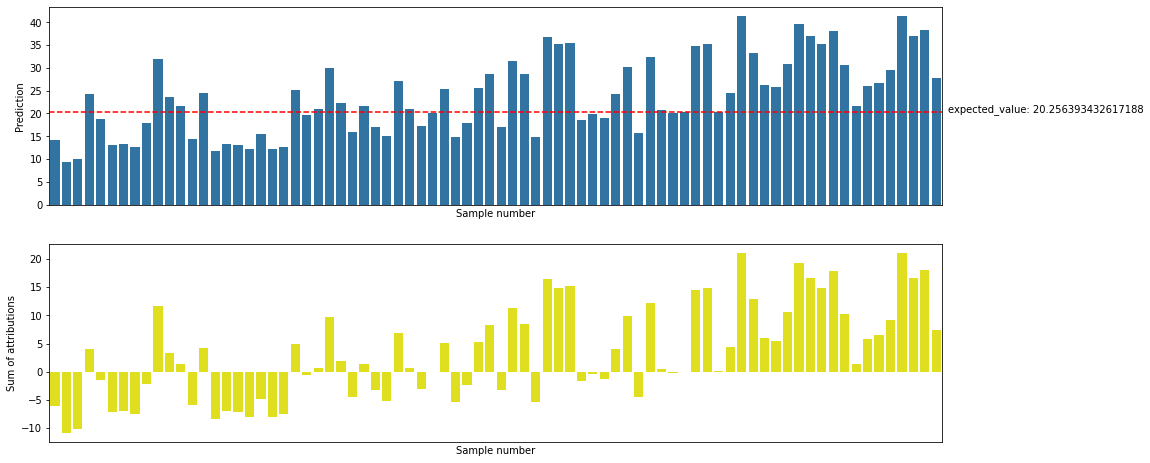

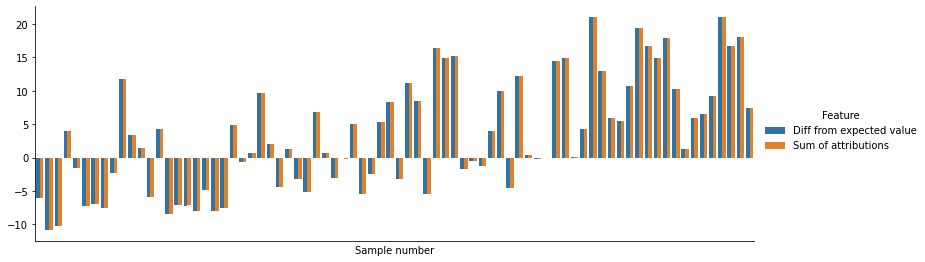

In [0]:
# Instantiate
ig = IntegratedGradients(model)

# Pick a baseline
baseline_pt = baseline_0_pt
#baseline_pt = baseline_mean_pt
#baseline_pt = baseline_05_pt
#baseline_pt = baseline_real_dist_pt

# Expected value for the selected baseline
expected_value = model(baseline_pt).clone().to('cpu').detach().flatten().numpy()[0]

# Explain
n_steps = 50 
# -------------------------------------
ig_attributions_pt = ig.attribute(X_test_pt, n_steps=n_steps,
                                         baselines=baseline_pt) 
ig_attributions = ig_attributions_pt.clone().to('cpu').detach().numpy()
sum_attributions = ig_attributions.sum(axis=1)

print("n_steps: {}, Max unexplained difference across samples: {}"\
.format(n_steps, 
        max(abs(sum_attributions - (test_predictions - expected_value)))))

# The explanation algorith will yield a more precise attribution with more steps
# i.e.: the difference between:
# - sum of attributions and
# - expected_value - model's prediction per sample
# will be closer to 0

n_steps = 500 
# -------------------------------------
ig_attributions_pt = ig.attribute(X_test_pt, n_steps=n_steps,
                                         baselines=baseline_pt) 
ig_attributions = ig_attributions_pt.clone().to('cpu').detach().numpy()
sum_attributions = ig_attributions.sum(axis=1)

print("n_steps: {}, Max unexplained difference across samples: {}"\
.format(n_steps, 
        max(abs(sum_attributions - (test_predictions - expected_value)))))

# Plot
plot_diff_explained(test_predictions, expected_value, sum_attributions)

Attributions sum up to the difference between model's output and the expected value (model's output for the baseline vector).

# Explain with SHAP 

---

Now let's try to assign feature importance with a simple, straightforward implementation of the SHAP algorithm.


__[Wiki Shapley value](https://en.wikipedia.org/wiki/Shapley_value)__


<center>
$\varphi _{i}(v)={\frac {1}{N}}\sum _{S\subseteq N\setminus \{i\}}{\binom {N-1}{|S|}}^{-1}(v(S\cup \{i\})-v(S))$
</center>

## Simple implementation of SHAP 

This is a toy straightforward implementation of the Shapley Values algorithm for one-actor coalitions.

In [0]:
def simple_shap_all_samples(X_samples, X_baseline, model_fn):
    '''Calculates shap values for an array of samples'''

    def simple_shap_one_sample(x_sample):
        '''Calculates shap values for one sample.'''

        N = X_samples.shape[-1]

        def shap_i(x_sample, i: int) -> float:
            '''Calculates shap values for the i-th element of a sample.'''
                
            all_subsets_minus_i = list(filter(lambda x: x[i] == 0, all_subsets))

            sum_i = 0
            for s in all_subsets_minus_i:
                model_output_si = \
                model_output_all_subsets[tuple(x if ii != i else 1 
                                               for ii, x in enumerate(s))]
                model_output_s = model_output_all_subsets[s]                                  
                v_si_subtract_v_s = model_output_si - model_output_s
                s_len = len([x for x in s if x == 1])
                sum_i += v_si_subtract_v_s / binom_s_all[s_len]

            return sum_i / N


        # Helper functions        
        def subset2inputs(x_sample, X_baseline, subset): 
            '''Elements in x_sample absent from the current subset 
            get replaced by reference values'''    
            return [ref if s==0 else x for x, ref, s 
                    in [(x, ref, s) for x, ref, s 
                        in zip(x_sample, X_baseline, subset)]]

        def tpl2indx(tpl, max_len):
            return tuple(1 if i in tpl else 0 for i in range(max_len+1))                     


        # Powerset of N elements as tuples of zeros and ones of length N
        powerset_n = chain.from_iterable(combinations(range(N), r) 
                                         for r in range(N + 1)) 
        all_subsets = [tpl2indx(x, N-1) for x in powerset_n]  
        binom_s_all = dict(zip(range(N), [int(scipy.special.binom(N-1, s)) 
                                          for s in range(N+1)]))

        # Precalculate model output for all subsets
        model_input_all_subsets = [subset2inputs(x_sample, X_baseline, s) 
                                          for s in all_subsets]                                
        model_output_all_subsets = dict(zip(all_subsets, 
                                            model_fn(model_input_all_subsets)))
        return np.array([shap_i(x_sample, i) for i in range(N)])

    # Return values for all samples
    return np.array([simple_shap_one_sample(x) for x in X_samples])

### Toy example: SHAP for the Glove game

The Wikipedia article on Shapley value uses an example of the __[Glove game](https://en.wikipedia.org/wiki/Shapley_value#Glove_game)__. Our simple implementation of SHAP can be used to calculate the contribution of individual players to the result of the game.

In [0]:
# Glove game score function

def score_glove_game(x):
    return [1*(any(xx==1 for xx in row[0:2]) and row[2]==1) for row in x]

model_fn = score_glove_game
X_baseline = [0, 0, 0]
#expected_value = model_fn([X_baseline])
X_samples =np.array([[1, 1, 1]])

shap_glove = simple_shap_all_samples(X_samples, X_baseline, model_fn)
print("simple shap glove: {}".format(shap_glove))
print("1/6, 1/6, 2/3 :", 1/6, 1/6, 2/3)

simple shap glove: [[0.16666667 0.16666667 0.66666667]]
1/6, 1/6, 2/3 : 0.16666666666666666 0.16666666666666666 0.6666666666666666


In the Wiki example:

$\varphi _{1}(v)=\!\left({\frac {1}{6}}\right)(1)={\frac {1}{6}}$

$ \varphi _{2}(v)=\varphi _{1}(v)={\frac {1}{6}}$

$\varphi _{3}(v)={\frac {4}{6}}={\frac {2}{3}}$

## Explain & plot

Let's now define a custom function for the MPG PyTorch model and see how SHAP algorithm assigns attributions to features.

In [0]:
# Parameters for car fuel efficiency model to be passed to the simple shap function

def model_car_fuel_efficiency(x):
    return model(torch.tensor(x).to(device).float()).reshape(-1).clone().\
    to('cpu').detach().numpy()

model_fn = model_car_fuel_efficiency

4.9954376635241715e-08


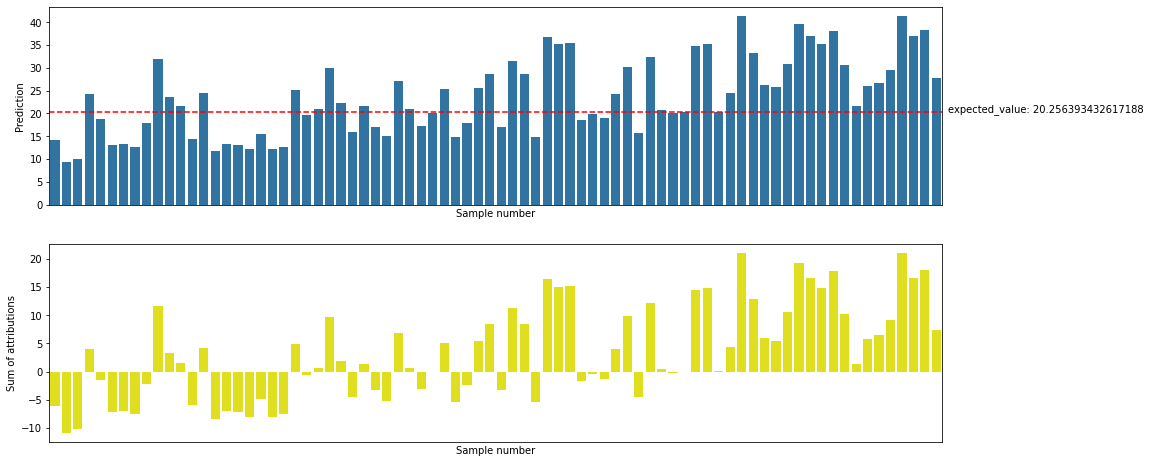

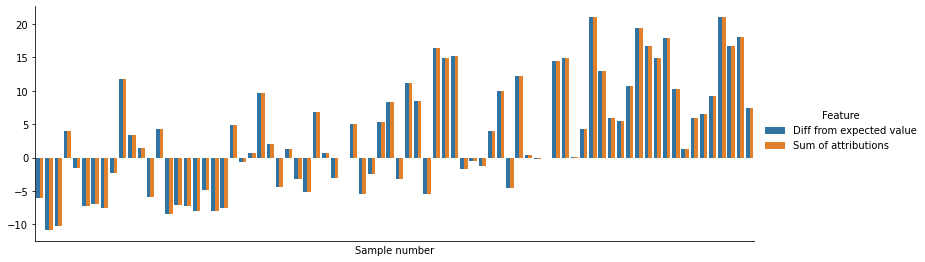

In [0]:
# Pick a baseline
baseline_pt = baseline_0_pt
#baseline_pt = baseline_mean_pt
#baseline_pt = baseline_05_pt
#baseline_pt = baseline_real_dist_pt

# Baseline to numpy
baseline = baseline_pt.clone().to('cpu').detach().numpy().squeeze()

# Expected value for the selected baseline
expected_value = model(baseline_pt).clone().to('cpu').detach().flatten().numpy()[0]

shap_attributions = simple_shap_all_samples(X_test, baseline, model_fn)
sum_attributions = shap_attributions.sum(axis=1)

# Max unexplained portion across samples in this test:
print(max(abs(sum_attributions - (test_predictions - expected_value))))

plot_diff_explained(test_predictions, expected_value, sum_attributions)

Attributions sum up to the difference between model's output and the expected value (model's output for the baseline vector).

# Visualization

---

## Helper functions

In [0]:
# Helper functions

def ig_attributions_for_baseline(X_test_pt, baseline_pt):
    # Expected value for the selected baseline
    ig_attributions_pt = ig.attribute(X_test_pt, n_steps=500, 
                                      baselines=baseline_pt) 
    ig_attributions = ig_attributions_pt.clone().to('cpu').detach().numpy()

    return ig_attributions, expected_value


def shap_attributions_for_baseline(X_test_pt, baseline_pt):
    def model_car_fuel_efficiency(x):
        return model(torch.tensor(x).to(device).\
                     float()).reshape(-1).clone().to('cpu').detach().numpy()
    model_fn = model_car_fuel_efficiency

    # Baseline to numpy
    baseline = baseline_pt.clone().to('cpu').detach().numpy().squeeze()

    # Expected value for the selected baseline
    expected_value = model(baseline_pt).clone().to('cpu').\
    detach().flatten().numpy()[0]

    shap_attributions = simple_shap_all_samples(X_test, baseline, model_fn)

    return shap_attributions, expected_value

Data used for visualization

In [0]:
# Calculate attributions for visualization

# ig
ig_attributions_baseline_0, _ = ig_attributions_for_baseline(X_test_pt, baseline_0_pt)
ig_attributions_baseline_mean, _ = ig_attributions_for_baseline(X_test_pt, baseline_mean_pt)
ig_attributions_baseline_05, _ = ig_attributions_for_baseline(X_test_pt, baseline_05_pt)
ig_attributions_baseline_real_dist, _ = ig_attributions_for_baseline(X_test_pt, baseline_real_dist_pt)

# shap
shap_attributions_baseline_0, _ = shap_attributions_for_baseline(X_test_pt, baseline_0_pt)
shap_attributions_baseline_mean, _ = shap_attributions_for_baseline(X_test_pt, baseline_mean_pt)
shap_attributions_baseline_05, _ = shap_attributions_for_baseline(X_test_pt, baseline_05_pt)
shap_attributions_baseline_real_dist, _ = shap_attributions_for_baseline(X_test_pt, baseline_real_dist_pt)

## Attribution values vs feature values

The diagrams below show how high and low values of features are distributed across the range of attributions assigned by IG and SHAP for various baselines. For some features, high values of the feature (in red) correlate with high values of attributions (x-axis), for some they gather in the lower range or there is no clear correlation.

In [0]:
attribution_column_names = ["Attribution_" + x for x in column_names[1:]]
# Plotting helper functions
def make_df(attributions, method, baseline):
    melted_features = pd.melt(pd.DataFrame(X_test, columns=column_names[1:]),
                              value_vars=column_names[1:],
                              var_name="Feature_name", value_name="Feature_value")

    melted_attributions = pd.melt(pd.DataFrame(attributions, 
                                  columns=attribution_column_names),
                              value_vars=attribution_column_names,#df_attributions.columns,
                              var_name="Feature_name", 
                              value_name="Attribution_value")

    df_melted = melted_features.copy()
    df_melted["Attribution_value"] = melted_attributions.Attribution_value

    df_melted["Method"] = method
    df_melted["Baseline"] = baseline

    return df_melted


# Data dependent on the attribution method and baseline selected
config = {"ig": {"baseline 0": ig_attributions_baseline_0,
                 "baseline mean": ig_attributions_baseline_mean,
                 "baseline 05": ig_attributions_baseline_05,
                 "baseline real sample": ig_attributions_baseline_real_dist},
          "shap": {"baseline 0": shap_attributions_baseline_0,
                 "baseline mean": shap_attributions_baseline_mean,
                 "baseline 05": shap_attributions_baseline_05,
                 "baseline real sample": shap_attributions_baseline_real_dist}}


def make_scatterplot(method, baseline, ax, legend=False):
    df = make_df(config[method][baseline], method, baseline)
    ax.set_title(method + " " + baseline)
    g = sns.scatterplot(data=df.reset_index(),
                           x="Attribution_value",
                           y="Feature_name",
                           hue="Feature_value",
                           palette=palette,
                           s=150, alpha=0.2,
                           ax=ax, legend=legend)
    ax = g.axes
    ax.axvline(0, color="grey")

    return g    

Plot

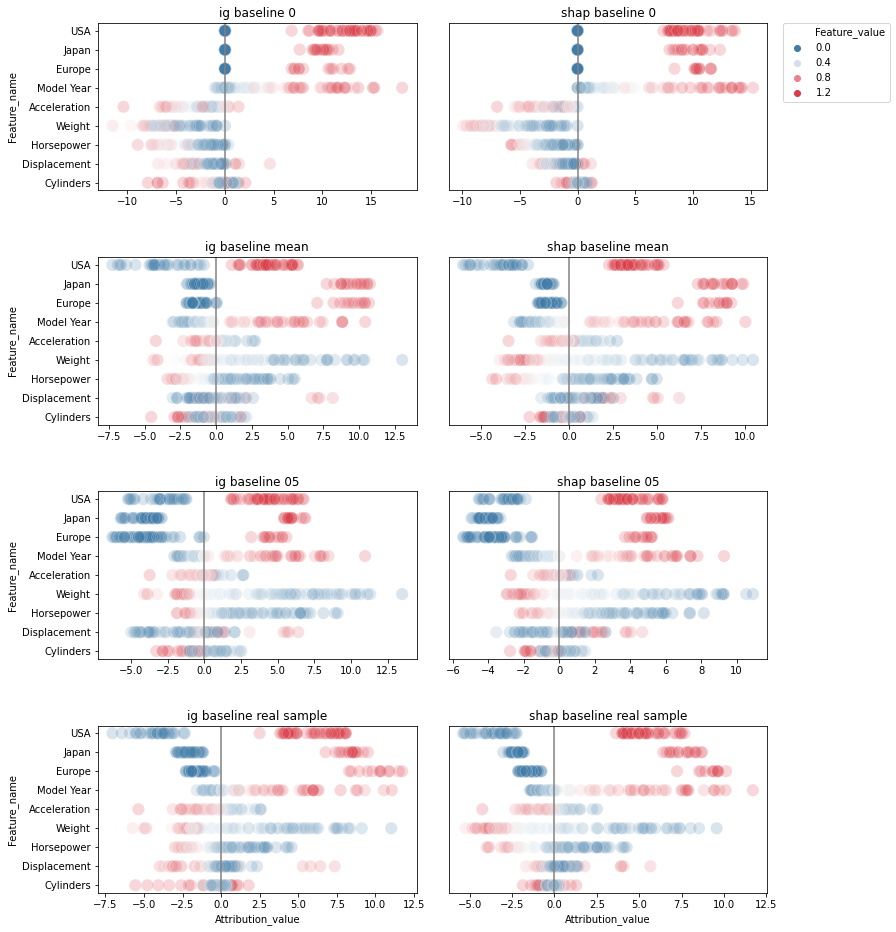

In [0]:
palette = sns.diverging_palette(240, 10, as_cmap=True)

fig = plt.figure(figsize=(12, 16))

gs = gridspec.GridSpec(nrows=4,
                       ncols=2, 
                       figure=fig,
                       width_ratios=[1, 1],
                       height_ratios=[1, 1, 1, 1],
                       wspace=0.1,
                       hspace=0.4)

ax1 = fig.add_subplot(gs[0, 0])
g = make_scatterplot("ig", "baseline 0", ax1)
g.set(xlabel="")

ax2 = fig.add_subplot(gs[0, 1])
g = make_scatterplot("shap", "baseline 0", ax2, legend='brief')
g.set(yticklabels=[], yticks=[], xlabel="", ylabel="")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax3 = fig.add_subplot(gs[1, 0])
g = make_scatterplot("ig", "baseline mean", ax3)
g.set(xlabel="")

ax4 = fig.add_subplot(gs[1, 1])
g = make_scatterplot("shap", "baseline mean", ax4)
g.set(yticklabels=[], yticks=[], ylabel="")
g.set(xlabel="")

ax5 = fig.add_subplot(gs[2, 0])
g = make_scatterplot("ig", "baseline 05", ax5)
g.set(xlabel="")

ax6 = fig.add_subplot(gs[2, 1])
g = make_scatterplot("shap", "baseline 05", ax6)
g.set(yticklabels=[], yticks=[], ylabel="")
g.set(xlabel="")

ax7 = fig.add_subplot(gs[3, 0])
g = make_scatterplot("ig", "baseline real sample", ax7)

ax8 = fig.add_subplot(gs[3, 1])
g = make_scatterplot("shap", "baseline real sample", ax8)
g.set(yticklabels=[], yticks=[], ylabel="")

plt.ioff()

Looking at the plots, we can observe that the relationship between feature values and attributions varies more with baselines than with attributions methods.

## Attributions for a selected feature

How do attributions depend on the feature value for an individual feature? Below we can pick one characteristic of a car (one feature, e.g.: weight), plot it against attributions and compare with the its correlation to model's predictions.

Pick a feature

In [0]:
# Set feature index
feature_indx = 3
feature_name = column_names[1:][feature_indx]
print("Feature:", feature_name)

def make_df(attributions, method, baseline):
    df = pd.DataFrame(X_test[:, feature_indx], columns=[feature_name])
    df['Attribution'] = attributions[:, feature_indx]
    df['Origin'] = dataset_raw.Origin
    df['Method'] = method
    df['Baseline'] = baseline

    return df

df_plot = pd.DataFrame(columns=
                       [feature_name, "Attribution", "Origin", "Method", "Baseline"])

for method in config.keys():
    for baseline in config[method].keys():
        attributions = config[method][baseline]
        df = make_df(attributions, method, baseline)
        df_plot = pd.concat([df_plot, df], axis=0)
     

Feature: Weight


Plot feature values against model's predictions and feature values against attributions

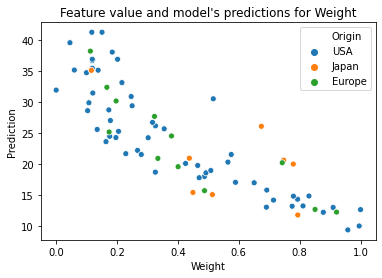

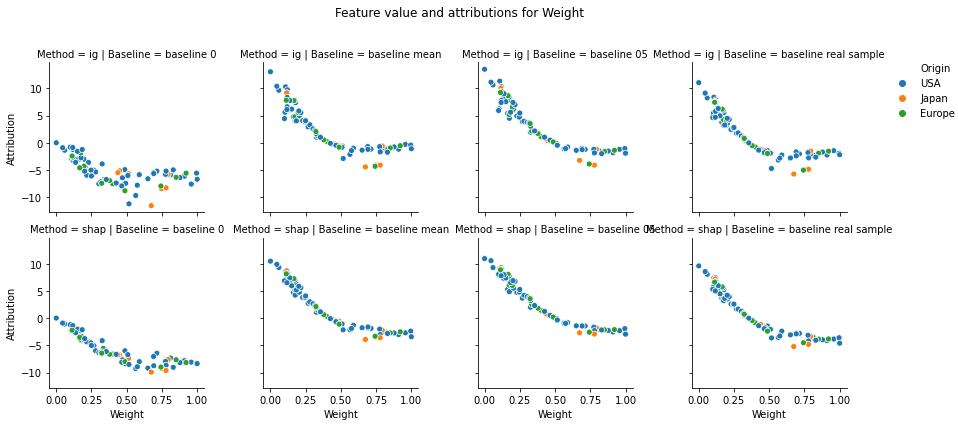

In [0]:
# Plot model's predictions against value of the selected feature
df = pd.DataFrame(X_test[:, feature_indx], columns=[feature_name])
df['Origin'] = dataset_raw.Origin
df['Prediction'] = test_predictions
g = sns.scatterplot(data=df, x=feature_name, y="Prediction", hue="Origin")
g.set_title("Feature value and model's predictions for " + feature_name)

# Plot attributions assigned by different methods agains feature values
g = sns.FacetGrid(df_plot, row="Method",  col="Baseline")
g = g.map(sns.scatterplot, feature_name, "Attribution", "Origin")
g.add_legend(bbox_to_anchor=(0.95, 0.85), loc=2, borderaxespad=0.)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Feature value and attributions for " + feature_name)

plt.ioff()

## Impact of features

Now let's plot the sum of attributions assigned to features by IG and SHAP for various baselines.
Note that the baseline vector is used to represent the absence of a feature. In our example, the input data is normalized to [0, 1]. For the "baseline 0" (a vector of zeros), substitution for a missing feature means replacing it with a lower value (with a 0). For other baselines this is not always the case, since some feature originally take values lower than the baseline of e.g.: 0.5 (for "baseline mean").

Helper functions

In [0]:
df_plot = pd.DataFrame(columns=["Method", "Baseline"] + column_names[1:])

for method in config.keys():
    for baseline in config[method].keys():
        attributions = config[method][baseline]
        df = pd.DataFrame(attributions, columns=column_names[1:])
        df['Method'] = method
        df['Baseline'] = baseline
        df_plot = pd.concat([df_plot, df], axis=0)

melted = pd.melt(df_plot, id_vars=['Baseline', 'Method'], 
                 value_vars=column_names[1:],
                 var_name="Feature", value_name="Attribution")
melted["Sign"] = ["Positive" if x >= 0 else "Negative" for x in melted.Attribution]

melted_sum = melted.groupby(['Baseline', 'Method', 'Feature', 'Sign'], 
                            as_index=False).sum()

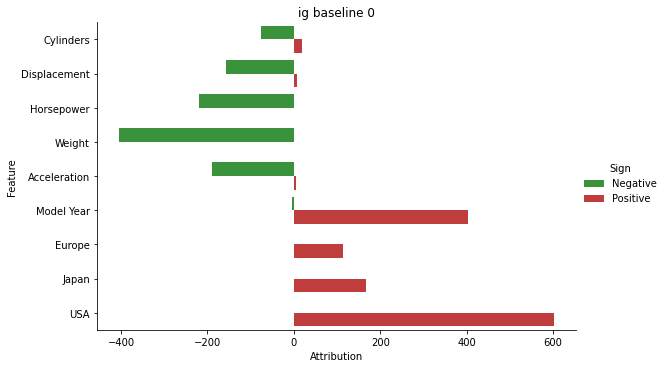

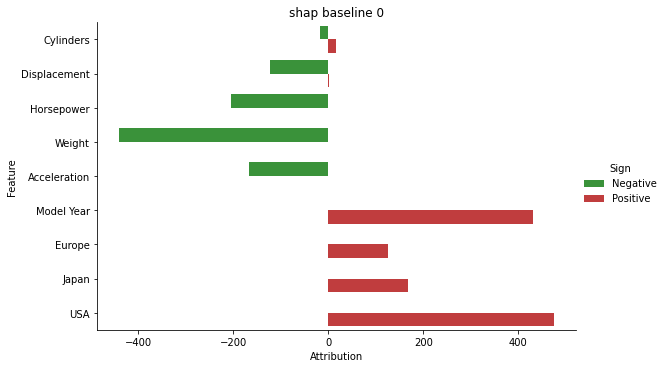

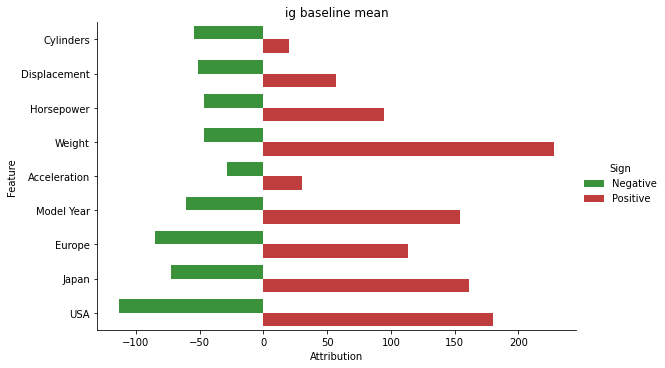

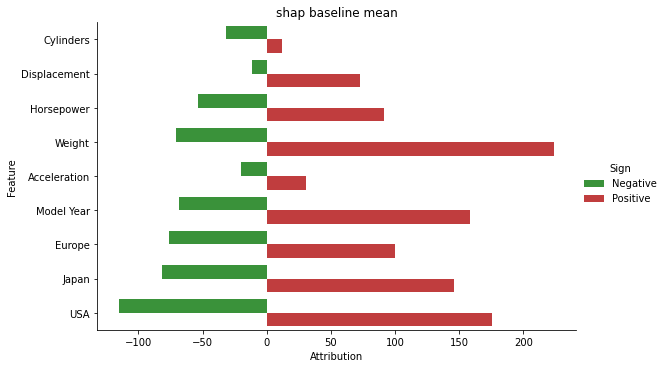

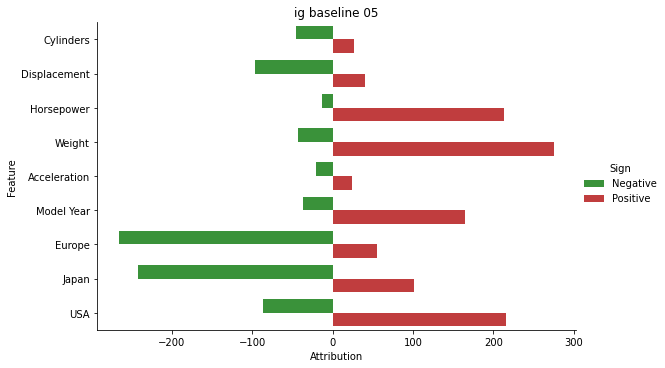

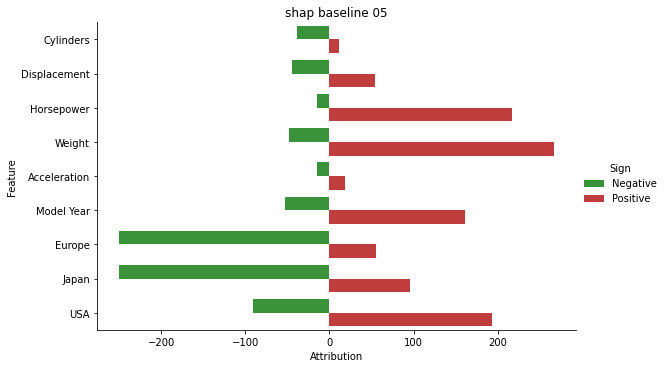

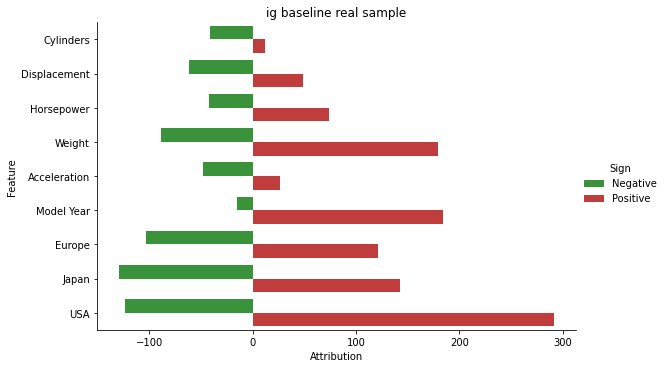

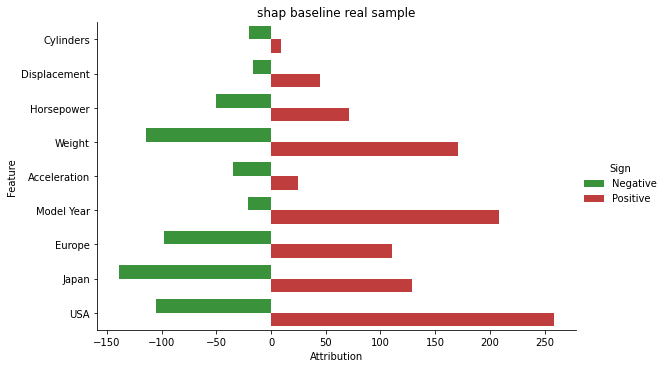

In [0]:
# Plot the sum of positive and negative attributions, sort by baselien first

for baseline in config[list(config.keys())[0]].keys():
    for method in config.keys():
        df = melted_sum[(melted_sum.Method==method) & (melted_sum.Baseline==baseline)]

        g = sns.catplot(x="Attribution", y="Feature", hue="Sign", 
                    data=df, kind="bar", errwidth=0, aspect=5/3,
                    palette=sns.color_palette()[2:], order=column_names[1:])
        ax = plt.gca()
        ax.set_title(method + " " + baseline)

As we can see, accumulated feature importance varies more between baselines than it does between attribution methods. One intuitive explanation is that since both methods use a baseline to stand for a missing value, features that have close to monotonic relationship to the target will be more consistently attributed a higher absolute impact when replaced by a zero.

# References 

---

https://captum.ai/docs/extension/integrated_gradients

https://github.com/pytorch/captum/blob/master/docs/extension/integrated_gradients.md

[Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)

https://www.tensorflow.org/tutorials/keras/regression

https://en.wikipedia.org/wiki/Shapley_value